<img src='https://tva1.sinaimg.cn/large/007S8ZIlgy1ger772p2t6j318c0t6gwl.jpg' width='30%'>

In [1]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import sys; sys.path.insert(0, '../')
from exp import nb_d2l_utils
%matplotlib inline

In [2]:
torch.manual_seed(0)
# torch.cuda.manual_seed_all(0)

torch.__version__               # PyTorch version
# torch.version.cuda              # Corresponding CUDA version
# torch.backends.cudnn.version()  # Corresponding cuDNN version
# torch.cuda.get_device_name(0)   # GPU type

dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((28,28)),
    transforms.ToTensor(),
])

train_data = torchvision.datasets.FashionMNIST('path/to/imagenet_root/', transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=4)

vali_data = torchvision.datasets.FashionMNIST('path/to/imagenet_root/', train=False, transform=transform, download=True)
vali_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=4)
            
X, y = iter(train_loader).next()
X.shape, y.shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [104]:
#export
import re
import typing
from collections import namedtuple
import torch

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()


def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, typing.Iterable): return list(o)
    return [o]


class Runner():
    """
    begin_fit
        begin_epoch
            begin_batch
            after_pred
            after_loss
            after_backward
            after_step
            after_batch
        begin_validate
            begin_batch
            after_pred
            after_loss
            after_backward
            after_step
            after_batch
        after_epoch
    after_fit
    """

    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop = False
        self.cbs = [TrainEvalCallback()] + cbs

    @property
    def opt(self):
        return self.learn.opt

    @property
    def model(self):
        return self.learn.model

    @property
    def loss_func(self):
        return self.learn.loss_func

    @property
    def data(self):
        return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')
        

    def all_batches(self, dl):
        self.iters = len(dl)  # howmany batches in one epoch
        try:
            for xb,yb in dl: 
                if self.stop: break
                self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')
        finally:
            self.stop = False

    def fit(self, epochs, learn):
        self.epochs, self.learn = epochs, learn

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'):  # through every callback's begin_epoch function
                    self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): 
                        self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
        except CancelTrainException: self('after_cancel_fit')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): 
            res = cb(cb_name) or res
        return res


class Callback:
    _order = 0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)

    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

In [109]:
#export
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0.
        self.run.n_iter = 0

    def begin_epoch(self):
        self.run.n_epochs = self.epoch
        self.model.train()
        self.run.in_train = True

    def after_batch(self):
        if not self.in_train:
            return
        self.run.n_epochs += 1. / self.iters
        self.run.n_iter += 1

    def begin_validate(self):
        self.model.eval()
        self.run.in_train = False


class AvgStats():
    def __init__(self, metrics, in_train):
        self.metrics, self.in_train = listify(metrics), in_train

    def reset(self):
        self.tot_loss, self.count = 0., 0
        self.tot_mets = [0.] * len(self.metrics)

    @property
    def all_stats(self):
        return [self.tot_loss.item()] + [i.item() for i in self.tot_mets]

    @property
    def avg_stats(self):
        return [o / self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i, m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn


class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats = AvgStats(metrics, True)
        self.valid_stats = AvgStats(metrics, False)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad():
            stats.accumulate(self.run)

    def after_epoch(self):
        print(f"epoch {self.epoch+1}: {self.train_stats} {self.valid_stats}")

        
class RecordCallback(Callback):
    def begin_fit(self):
        self.lrs = []
        self.losses = []
    
    def after_batch(self):
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        

class CudaCallback(Callback):
    def __init__(self,device): 
        self.device=device
        
    def begin_fit(self): 
        self.model.to(self.device)
        
    def begin_batch(self): 
        self.run.xb = self.xb.to(self.device)
        self.run.yb = self.yb.to(self.device)

In [106]:
class MnistLinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(784, 64)
        self.linear2 = torch.nn.Linear(64, 10)
    
    def forward(self, xb):
        xb = xb.view(-1,28*28)
        xb = self.linear1(xb).relu_()
        xb = self.linear2(xb).relu_()
        return xb
    
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data


def accuracy(out, yb): return (torch.argmax(out, dim=1) == yb).float().mean()


In [107]:
from functools import partial

model = MnistLinear()
learn = Learner(
    model=model,
    opt=torch.optim.Adam(model.parameters(), lr=1e-2),
    loss_func=torch.nn.CrossEntropyLoss(),
    data=namedtuple('data', ['train_dl', 'valid_dl'])(train_loader, vali_loader),
)

cbs = [
    partial(AvgStatsCallback, accuracy),
    RecordCallback
]
runner = Runner(cb_funcs=cbs)
runner.fit(3, learn)

epoch 1: train: [1.968914453125, 0.27398333333333336] valid: [1.93708203125, 0.27855]
epoch 2: train: [1.9389013020833332, 0.2803] valid: [1.9219404947916667, 0.2863]
epoch 3: train: [1.9319018229166667, 0.28165] valid: [1.9335846354166666, 0.2764666666666667]


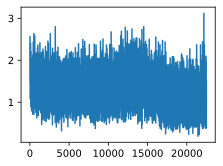

In [87]:
nb_d2l_utils.plt.plot(runner.record.losses)

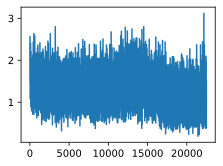

In [95]:
nb_d2l_utils.plot([i.item() for i in runner.record.losses])

In [111]:
!python notebook2script.py [Advanced]\ CallBack.ipynb callback.py
!ls exp

import sys; sys.path.insert(0, '../')
from exp import callback

dir(callback)

Converted [Advanced] CallBack.ipynb to exp/callback.py
__init__.py     __pycache__     callback.py     nb_d2l_utils.py


['AvgStats',
 'AvgStatsCallback',
 'Callback',
 'RecordCallback',
 'Runner',
 'TrainEvalCallback',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_camel_re1',
 '_camel_re2',
 'camel2snake',
 'listify',
 'namedtuple',
 're',
 'torch',
 'typing']